# **Project 2**  
*AEEM 2058*  
*Date*:12/3/2025  
Hayden Mays, Logan Mueller, Evan Wills  
___

In [86]:
# Haydens Version
# Imports
import numpy as np
import matplotlib.pyplot as plt

## **A**   
___

### Solving Functions

In [87]:
def RK4(y,system:callable,h,t):
    k1=system(t,y)
    k2=system(t+h/2,y+(k1/2)*h)
    k3=system(t+h/2,y+(k2/2)*h)
    k4=system(t+h,y+(k3)*h)  
    
        
        # Update y value using the weighted average of the slopes
    y=y+(1/6)*(k1+2*k2+2*k3+k4)*h
    return y

def Euler(t_0:float,t_f:float,h:float,S_initial:float,dSdt:callable)-> tuple [np.ndarray:'S values',np.ndarray]:
    ''' Runs Euler method
    
    Args:
        t_0: the initial time
        t_f: the finial time
        h: the step length between the initial and finial time
        S_initial: the initial condition
        dSdt: the ODE for S
        
    Returns:
        tuple of 2 arrays
        (t_span,S)
        
    '''
    t_span=np.arange(t_0,t_f+h,h) # creates span
    
    S=np.zeros((len(t_span),4)) # Creates array for outputs
    S[0]=S_initial #Sets intial value
    
    # Runs euler aproximation
    for i in range(len(t_span)-1):
        S[i+1]=S[i]+h*dSdt(t_span[i],S[i])
    
    # Returns t_span and the outputs
    return t_span,S

def system(t,state):
    x,z,v_x,v_z=state
    g=9.8 #m/s^2
    c=1e-3 #m^-1
    dx=v_x
    dz=v_z
    v=np.sqrt(v_x**2+v_z**2)
    dv_x=-c*v_x*v
    dv_z=-g-c*v_z*v
    
    return np.array([dx,dz,dv_x,dv_z])

### Funcions For Solution

In [88]:

def z_zero(theta,v,t_initial,target,t_step):
    vx=v*np.cos(np.deg2rad(theta))
    vz=v*np.sin(np.deg2rad(theta))
    sol=np.array([0,0,vx,vz])
    t=t_initial
    z=1
    
    while z>0.0:
        sol=RK4(sol,system,t_step,t)
        t+=t_step
        z=sol[1]
    if sol[0]<target:
      return None
    return t



def find(theta,v_range,target,t_initial,t_step):
    for v in v_range:
        t_f=z_zero(theta,v,t_initial,target,t_step)
        if t_f!=None:
            return [theta,v,t_f]
    return None



def solve_v0(target,t_initial,t_step,theta,v_min,v_max,v_step= 1000.0):
    
    v_range=np.arange(v_min,v_max+v_step,v_step)
    sol=find(theta,v_range,target,t_initial,t_step)
    if sol==None:
        # print(f'None For {theta}')
        return None,None,None
    if v_step>.001:
        return solve_v0(target,t_initial,t_step,theta,sol[1]-v_step,sol[1],v_step/10)
    else:
         return sol


def Solve_Best(target_x, angles=np.arange(0, 80 , 5)):
    best = None

    for theta in angles:
        _,v0,tf = solve_v0(target_x,0,0.01,theta,0,500)
        if v0 != None and (best is None or v0 < best[1]):
            best = (theta, v0,tf)

    return best


### Test

In [89]:
target=804.5
best=Solve_Best(target)
print(f"Best Tested Values:\nAngle:{best[0]:5.2f}\nVelocity:{best[1]:6.2f}")

Best Tested Values:
Angle:40.00
Velocity:128.19


### Verify

Initail:
X:  0.00 m | Z:  0.00 m | V:128.19 m/s

Finial:
X:804.53 m | Z: -0.57 m | V: 68.72 m/s


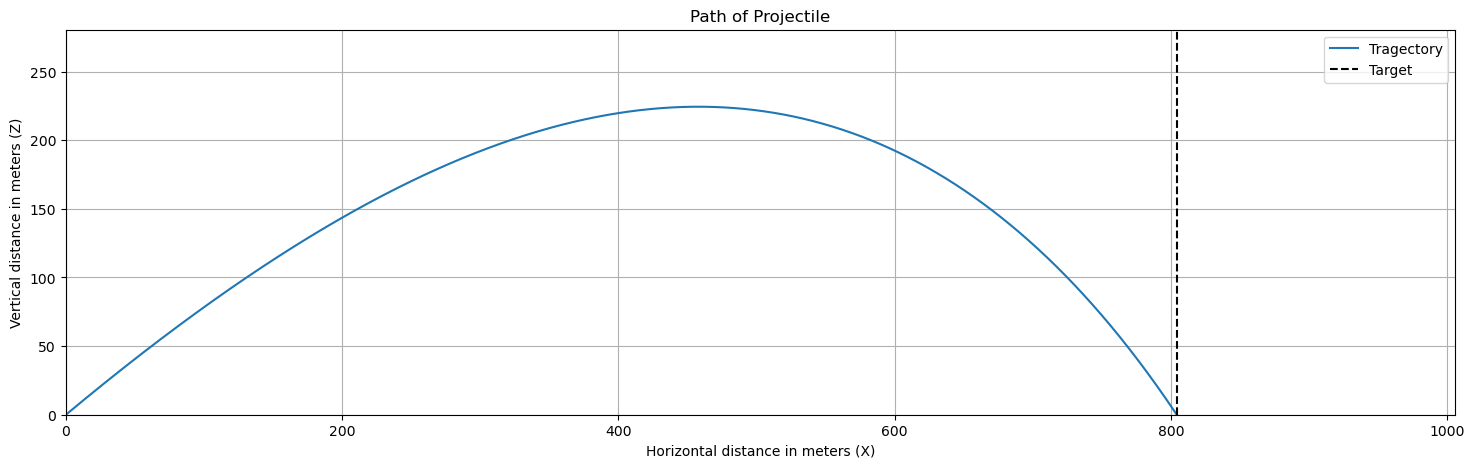

In [96]:
v0=best[1] #m/s
theta0=best[0]
t_initial=0
t_step=0.0001

y0=np.array([0,0,v0*np.cos(np.deg2rad(theta0)),v0*np.sin(np.deg2rad(theta0))])

t_c,v=Euler(t_initial,best[2],t_step,y0,system)

initial=v[0]
finial=v[len(v)-1]
print(f'Initail:\nX:{initial[0]:6.2f} m | Z:{initial[1]:6.2f} m | V:{np.sqrt(initial[2]**2+initial[3]**2):6.2f} m/s\n')
print(f'Finial:\nX:{finial[0]:6.2f} m | Z:{finial[1]:6.2f} m | V:{np.sqrt(finial[2]**2+finial[3]**2):6.2f} m/s')

v=v.T
figscale=5
plt.figure(figsize=(figscale*v[0].max()/v[1].max(),figscale))
plt.plot(v[0],v[1],label='Tragectory')
plt.xlabel("Horizontal distance in meters (X)")
plt.ylabel("Vertical distance in meters (Z)")
plt.title("Path of Projectile")
plt.vlines(target,0,v[1].max()*1.25,linestyles='--',colors='black',label='Target')
plt.ylim((0,v[1].max()*1.25))
plt.xlim((0,v[0].max()*1.25))
plt.grid()
plt.legend()
plt.show()

Initial Velocity: 129.947 m/s
Initial Angle: 45.000°

   Time   |   X Velocity  |  Y Velocity  
------------------------------------------


Range: 949.909 m | 0.590 Mile(s)
Finial Z: -386.049 m

[0.00000000e+00 9.18864049e-03 1.83771616e-02 ... 9.49909977e+02
 9.49912199e+02 9.49914420e+02]
[ 0.00000000e+00  9.18864049e-03  1.83770636e-02 ... -3.86031695e+02
 -3.86039972e+02 -3.86048250e+02]


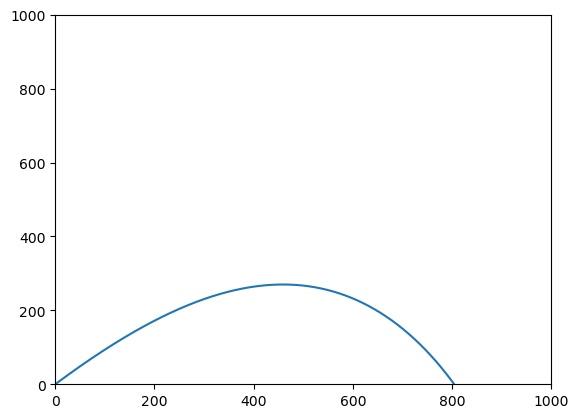

In [91]:
t_initial=0
t_finial=20
t_step=0.0001
N=int((t_finial-t_initial)/t_step)



v0=129.947 #m/s
theta0=45

y0=np.array([0,0,v0*np.cos(np.deg2rad(theta0)),v0*np.sin(np.deg2rad(theta0))])

t_c,v=Euler(t_initial,t_finial,t_step,y0,system)
v_x=v.T[2]
trapx=(t_step/2)*(v_x[0]+ 2*sum(v_x[1:N-1])+v_x[N-1])

v_z=v.T[3]
trapz=(t_step/2)*(v_z[0]+ 2*sum(v_z[1:N-1])+v_z[N-1])

print(f'Initial Velocity: {v0:0.03f} m/s')
print(f'Initial Angle: {theta0:0.03f}°\n')

print('Time'.center(10)+'|'+'X Velocity'.center(15)+'|'+'Y Velocity'.center(14))
print(''.center(42,'-'))
# for t,vx,vz in zip(t_c,v_x,v_z):
#     print(f'{t:7.03f} s | {vx:8.03f} m/s | {vz:8.03f} m/s'.center(42),end='\r',flush=False)
#     #time.sleep(t_step)

print(f'\n\nRange: {trapx:0.03f} m | {trapx/1609:0.03f} Mile(s)')

print(f'Finial Z: {trapz:0.03f} m\n')
print(v.T[0])
print(v.T[1])
plt.plot(v.T[0],v.T[1])
plt.ylim((0,1000))
plt.xlim((0,1000))
plt.show()

## B
___

Discusion

## C
---

In [92]:

def z_zero(z0,theta,v,t_initial,target,t_step):
    vx=v*np.cos(np.deg2rad(theta))
    vz=v*np.sin(np.deg2rad(theta))
    sol=np.array([0,z0,vx,vz])
    t=t_initial
    z=1
    
    while z>0.0:
        sol=RK4(sol,system,t_step,t)
        t+=t_step
        z=sol[1]
    if sol[0]<target:
      return None
    return t



def find(z0,theta,v_range,target,t_initial,t_step):
    for v in v_range:
        t_f=z_zero(z0,theta,v,t_initial,target,t_step)
        if t_f!=None:
            return [theta,v,t_f]
    return None



def solve_v0(target,t_initial,t_step,theta,v_min,v_max,z0=0,v_step= 1000.0):
    
    v_range=np.arange(v_min,v_max+v_step,v_step)
    sol=find(z0,theta,v_range,target,t_initial,t_step)
    if sol==None:
        # print(f'None For {theta}')
        return None,None,None
    if v_step>.001:
        return solve_v0(target,t_initial,t_step,theta,sol[1]-v_step,sol[1],z0,v_step/10)
    else:
         return sol


def Solve_Best(target_x,z0=0, angles=np.arange(0, 80 , 5)):
    best = None

    for theta in angles:
        _,v0,tf = solve_v0(target_x,0,0.01,theta,0,500,z0)
        if v0 != None and (best is None or v0 < best[1]):
            best = (theta, v0,tf)

    return best


In [93]:
target=804.5
z0=804.5
best_alt=Solve_Best(target,z0)
print(f"Best Tested Values:\nAngle:{best[0]:5.2f}\nVelocity:{best[1]:6.2f}")

Best Tested Values:
Angle:40.00
Velocity:128.19


Initail:
X:  0.00 m | Z:804.50 m | V: 82.04 m/s

Finial:
X:804.51 m | Z: -0.47 m | V: 89.75 m/s


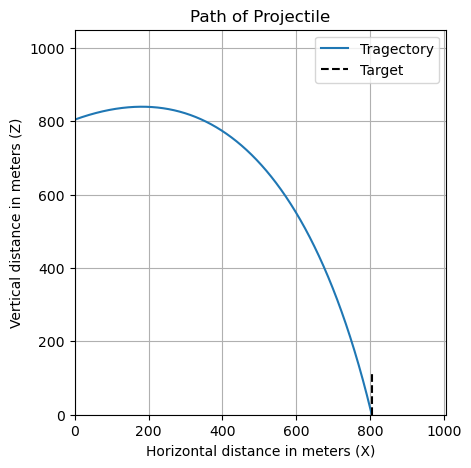

In [94]:
# Validation
v0=best_alt[1] #m/s
theta0=best_alt[0]
t_initial=0
t_step=0.0001

y0=np.array([0,z0,v0*np.cos(np.deg2rad(theta0)),v0*np.sin(np.deg2rad(theta0))])

t_c,v_alt=Euler(t_initial,best_alt[2],t_step,y0,system)

initial=v_alt[0]
finial=v_alt[len(v_alt)-1]
print(f'Initail:\nX:{initial[0]:6.2f} m | Z:{initial[1]:6.2f} m | V:{np.sqrt(initial[2]**2+initial[3]**2):6.2f} m/s\n')
print(f'Finial:\nX:{finial[0]:6.2f} m | Z:{finial[1]:6.2f} m | V:{np.sqrt(finial[2]**2+finial[3]**2):6.2f} m/s')

v_alt=v_alt.T
figscale=5
plt.figure(figsize=(figscale*v_alt[0].max()/v_alt[1].max(),figscale))
plt.plot(v_alt[0],v_alt[1],label='Tragectory')
plt.xlabel("Horizontal distance in meters (X)")
plt.ylabel("Vertical distance in meters (Z)")
plt.title("Path of Projectile")
plt.vlines(target,0,v[1].max()*1.25,linestyles='--',colors='black',label='Target')
plt.ylim((0,v_alt[1].max()*1.25))
plt.xlim((0,v_alt[0].max()*1.25))
plt.grid()
plt.legend()
plt.show()

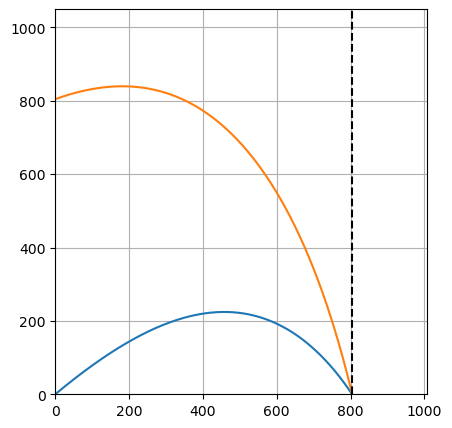

In [102]:
figscale=5
plt.figure(figsize=(figscale*v_alt[0].max()/v_alt[1].max(),figscale))
plt.plot(v[0],v[1],label='Tragectory z0=0')
plt.plot(v_alt[0],v_alt[1],label=f'Tragectory z0={z0}')
plt.ylim((0,v_alt[1].max()*1.25))
plt.xlim((0,v_alt[0].max()*1.25))
plt.vlines(target,0,v_alt[1].max()*1.25,linestyles='--',colors='black',label='Target')
plt.grid()
plt.show()